# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,


In [38]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [39]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [40]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

In [41]:
# celda 0 - exploracion y analisis de datos
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
    
print("Datos antes de limpieza:", data.shape)
print("Valores nulos por columna:")
print(data.isnull().sum())

data = data.dropna().drop_duplicates()

categorical_cols = data.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
data = pd.concat([data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
data = data.drop(categorical_cols, axis=1)

scaler = StandardScaler()
data[data.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(data.select_dtypes(include=['float64', 'int64']))


print("\nDatos después de limpieza:", data.shape)
print(data.describe())


Datos antes de limpieza: (10495, 10)
Valores nulos por columna:
Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

Datos después de limpieza: (10487, 10)
              Price          Year       Mileage
count  1.048700e+04  1.048700e+04  1.048700e+04
mean   9.485647e-17 -2.975377e-14 -2.303657e-17
std    1.000048e+00  1.000048e+00  1.000048e+00
min   -2.431863e+00 -4.990828e+00 -1.428794e+00
25%   -6.467085e-01 -4.977852e-01 -7.081492e-01
50%    1.189408e-01  1.440780e-01 -2.944217e-01
75%    6.286934e-01  7.859412e-01  5.120410e-01
max    4.569453e+00  1.427804e+00  4.897525e+00



Correlaciones con 'Price':
Price          1.000000
Year           0.842091
M_CamrySE      0.327511
M_CamryXLE     0.215266
M_CamryLE      0.023431
M_CamryL       0.008662
M_Camry       -0.118943
M_CamryBase   -0.152660
M_Camry4dr    -0.531310
Mileage       -0.833623
Name: Price, dtype: float64


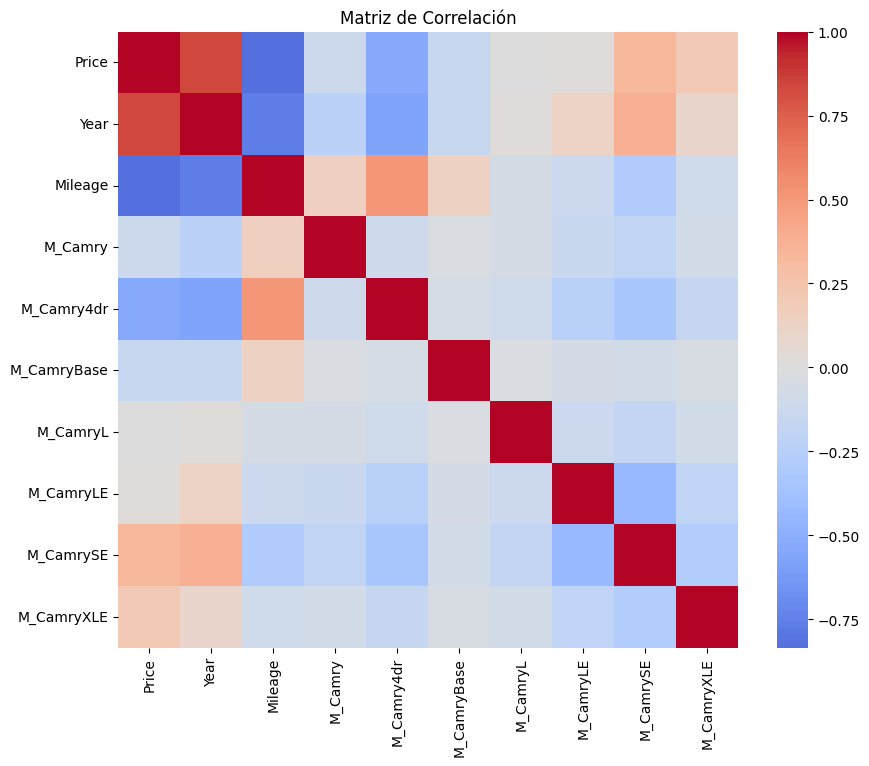

In [42]:

corr_matrix = data.corr()

print("\nCorrelaciones con 'Price':")
print(corr_matrix['Price'].sort_values(ascending=False).head(10))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [43]:
# Celda 1
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')

print("Desempeño del modelo RF:")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"R^2 Score: {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f} %")

Desempeño del modelo RF:
Mean Squared Error: 3,116,678.92
R^2 Score: 0.796
Mean Absolute Error (MAE): 1,314.42
Mean Absolute Percentage Error (MAPE): 9.55 %


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [33]:
# Celda 2
param_dist = {
    'max_depth': [10, 20, 30, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 200, 300, 500]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,         
    cv=5,              
    n_jobs=-1,         
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [44]:
#Encontrar los mejores hiperparametros: 
best_params = random_search.best_params_
print("\n#Encontrar los mejores hiperparámetros:\n")
print("Mejores Hiperparámetros:")
print(best_params)

#Entrenar el modelo con los mejores hiperparámetros encontrados:
from sklearn.metrics import mean_absolute_percentage_error
print("\n#Entrenar el modelo con los mejores hiperparámetros encontrados:\n")
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best) * 100
r2_best = r2_score(y_test, y_pred_best)

print(f"Desempeño del modelo RF calibrado:")
print(f"Mean Squared Error: {mse_best:,.2f}")
print(f"R^2 Score: {r2_best:.3f}")
print(f"Mean Absolute Error (MAE): {mae_best:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f} %")


#Encontrar los mejores hiperparámetros:

Mejores Hiperparámetros:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

#Entrenar el modelo con los mejores hiperparámetros encontrados:

Desempeño del modelo RF calibrado:
Mean Squared Error: 2,411,920.45
R^2 Score: 0.842
Mean Absolute Error (MAE): 1,140.84
Mean Absolute Percentage Error (MAPE): 8.33 %


In [ ]:
#Importancia de los predictores
print("\n#Importancia de los predictores\n")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(feature_importance.head(10))

       Feature  Importance
0         Year    0.448241
1      Mileage    0.424250
3   M_Camry4dr    0.066602
7    M_CamrySE    0.022088
8   M_CamryXLE    0.019215
6    M_CamryLE    0.007427
2      M_Camry    0.006767
4  M_CamryBase    0.002741
5     M_CamryL    0.002669


### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

 Comparación entre modelos:


,Modelo,R²,RMSE,MAE
0,Base,0.796244,1765.411826,1314.420708
1,Optimizado,0.842318,1564.894714,1140.841294


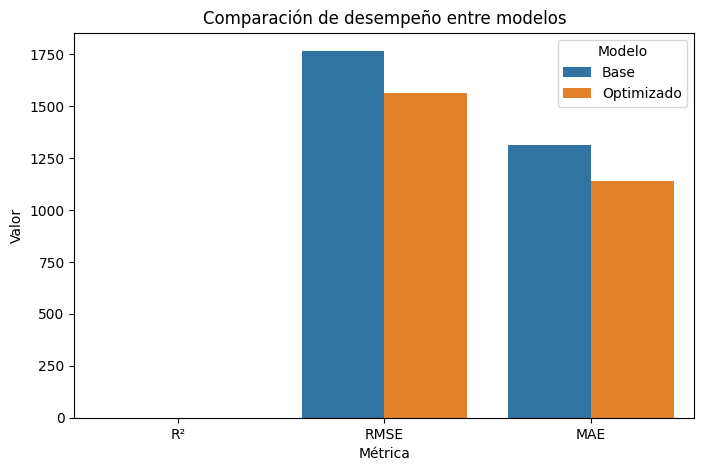

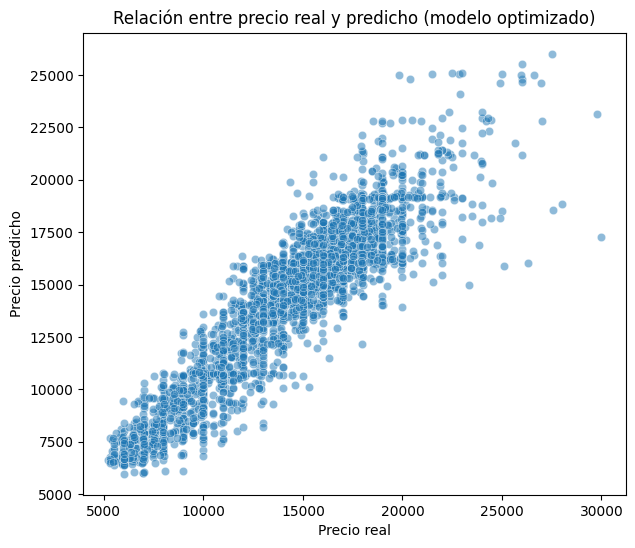

In [47]:
#celda 3

results = pd.DataFrame({
    'Modelo': ['Base', 'Optimizado'],
    'R²': [r2, r2_best],
    'RMSE': [rmse, rmse_best],
    'MAE': [mae, mae_best]
})

print(" Comparación entre modelos:")
display(results)

results_melted = results.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')
plt.figure(figsize=(8,5))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=results_melted)
plt.title('Comparación de desempeño entre modelos')
plt.show()

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Relación entre precio real y predicho (modelo optimizado)')
plt.show()

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.